In [1]:
import uproot
import awkward as ak

import numpy as np
import pickle
import matplotlib.pyplot as plt

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, auc

import torch
import torch.nn
import torch.optim
import torch.utils.data

import time
import math
import xmltodict
import json


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from LearningCutsUtils.ScanNetwork import ScanNetwork
from LearningCutsUtils.LossFunctions import full_loss_fn

In [2]:
campaigns=["mc23a",
           "mc23d",
           "mc23e"]

targeteffics=[0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.97,0.98,0.99]
conv_type=["unconverted"]
eta_bins=["0.0","0.6"]
loose_pt_bins=[7,10,15,20,25,30,35,40,50,1000] # only needed for loose tuning
pt_bins=[7,10,15,20,25,30,35,40,45,50,60,80,100,125,150,175,500,1000] # good for medium and tight
#mu_bins=[0,20,30,40,50,60]
mu_bins=[0,60]
branches = ['y_pt_custom','y_eta_custom','y_Rhad','y_Rhad1','y_Reta','y_Rphi','y_weta2','y_Eratio','y_deltae','y_wtots1','y_fracs1','y_weta1','evt_mu']
training_branches = ['y_Rhad','y_Reta','y_Rphi','y_weta2','y_Eratio','y_deltae','y_wtots1','y_fracs1','y_weta1']

# don't do the last pT bin, not worth it
N_pt_bins=len(pt_bins)-2
N_mu_bins=len(mu_bins)-1
pt_ranges=[(pt_bins[i],pt_bins[i+1]) for i in range(N_pt_bins)]
mu_ranges=[(mu_bins[i],mu_bins[i+1]) for i in range(N_mu_bins)]

In [3]:
arrays={}

for sb in ["sgn","bkg"]:
    arrays[sb]={}
    
    for conv in conv_type:
        arrays[sb][conv]={}
    
        for eta_i in range(len(eta_bins)-1):
            eta=eta_bins[eta_i]
            arrays[sb][conv][eta]={}
            
            for pt_i in range(len(pt_bins)-1):
                pt=pt_bins[pt_i]
                arrays[sb][conv][eta][pt]={}

                filetype="incl_ph"
                if pt<25:
                    filetype="rad_Z"
                
                tmpdata=[]
                for campaign in campaigns:
                    filespath=f"/data/ealmazan/optimised_files/results/{campaign}/{filetype}_{conv}/root_files/"
                    filename=f"{sb}_{conv}_{pt_bins[pt_i]}{pt_bins[pt_i+1]}_{eta_bins[eta_i]}{eta_bins[eta_i+1]}_160.root"
                    with uproot.open(filespath+filename) as infile:
                        tmpdata.append(infile["SinglePhoton"].arrays(branches))
                
                cat=ak.concatenate(tmpdata)
                
                for mu_i in range(len(mu_bins)-1):
                    mu = mu_bins[mu_i]
                    mumask=((cat['evt_mu'] > mu_bins[mu_i]) & (cat['evt_mu'] < mu_bins[mu_i+1]))
                    
                    arrays[sb][conv][eta][pt][mu] = ak.drop_none(ak.mask(cat, mumask))

In [4]:
for pt in pt_bins[:-1]:
    for mu in mu_bins[:-1]:
        print(f"pt={pt:5d}, mu={mu:3d}: N_sig = {len(arrays["sgn"]["unconverted"]["0.0"][pt][mu]['y_eta_custom']):8d}, N_bkg = {len(arrays["bkg"]["unconverted"]["0.0"][pt][mu]['y_eta_custom']):8d}")

pt=    7, mu=  0: N_sig =   235228, N_bkg =   102062
pt=   10, mu=  0: N_sig =   416322, N_bkg =    23564
pt=   15, mu=  0: N_sig =   333702, N_bkg =     3066
pt=   20, mu=  0: N_sig =   261250, N_bkg =      713
pt=   25, mu=  0: N_sig =   868577, N_bkg =   187840
pt=   30, mu=  0: N_sig =   667939, N_bkg =    99759
pt=   35, mu=  0: N_sig =  2377399, N_bkg =    78602
pt=   40, mu=  0: N_sig =  1775590, N_bkg =    50780
pt=   45, mu=  0: N_sig =  1302166, N_bkg =    36907
pt=   50, mu=  0: N_sig =  3711716, N_bkg =    60122
pt=   60, mu=  0: N_sig =  4353884, N_bkg =    42144
pt=   80, mu=  0: N_sig =  2300358, N_bkg =    11172
pt=  100, mu=  0: N_sig =  1237459, N_bkg =     4503
pt=  125, mu=  0: N_sig =  1421326, N_bkg =     1557
pt=  150, mu=  0: N_sig =  1762949, N_bkg =      568
pt=  175, mu=  0: N_sig =  9388599, N_bkg =      644
pt=  500, mu=  0: N_sig = 11850630, N_bkg =        8


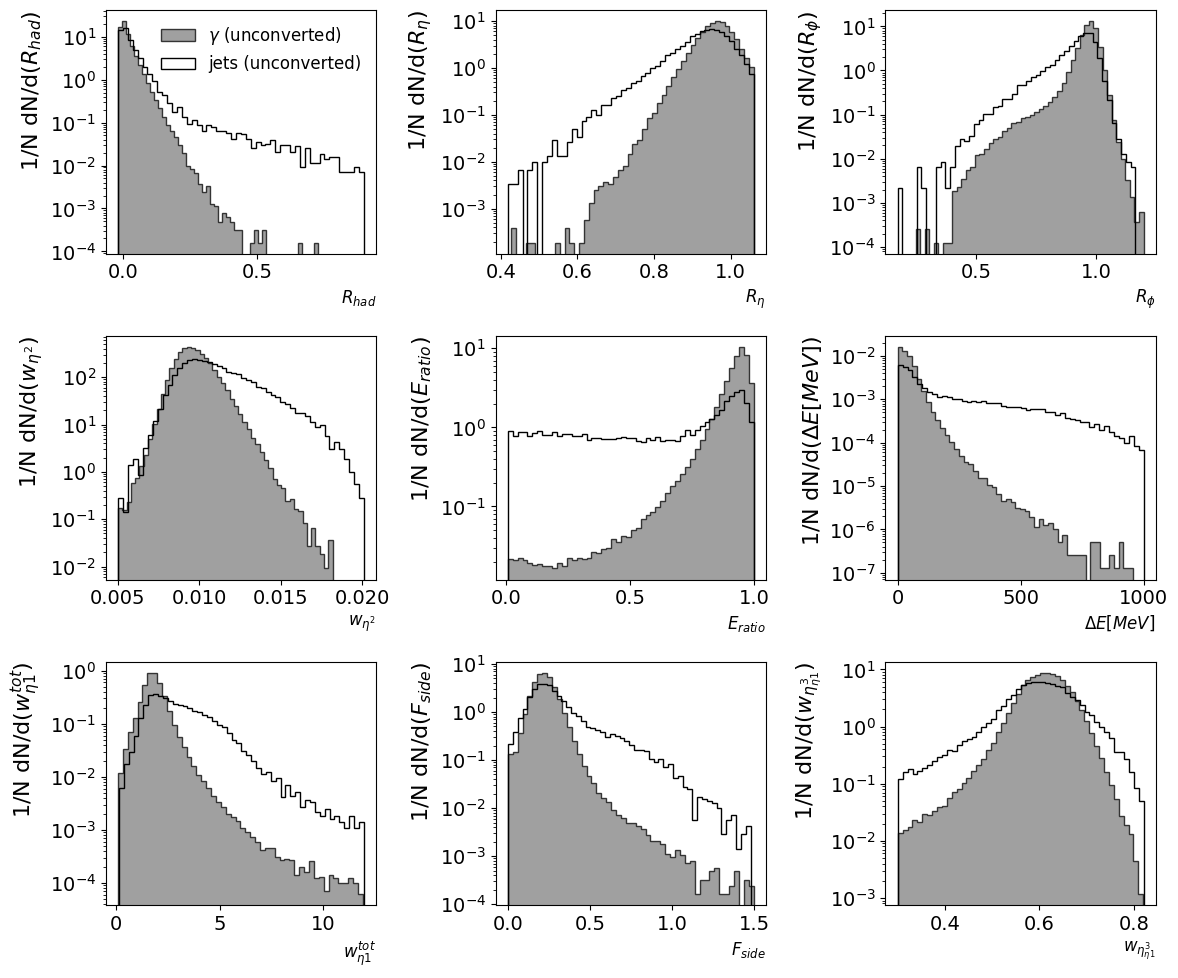

In [5]:
def plot_signal(bkg,sgn):
    feature_names = ['y_Rhad','y_Reta','y_Rphi','y_weta2','y_Eratio','y_deltae','y_wtots1','y_fracs1','y_weta1','y_pt_custom','evt_mu']
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12,10))
    ranges = [(-0.05,0.25),(0.2,1.1),(0.2,1.1),(0,0.025),(0,1),(0,8000),(0,15),(0,1.),(0,1.)]
    latex_string = ['$R_{{had}}$','$R_{{\\eta}}$','$R_{{\\phi}}$','$w_{{\\eta^{{2}}}}$','$E_{{ratio}}$','$\\Delta E [MeV]$','$w^{{tot}}_{{\\eta 1}}$','$F_{{side}}$','$w_{{\\eta^{{3}}_{{\\eta 1}}}}$','pt','mu']
    nbins = 50
    for i, ax in enumerate(axes.flatten()):
        ax.hist(sgn[feature_names[i]], density=True,bins=nbins,histtype = 'stepfilled',color='grey',alpha = 0.75, edgecolor='black', label = '$\\gamma$ (unconverted)')
        ax.hist(bkg[feature_names[i]],density=True,bins=nbins,histtype = 'step',color='white',alpha = 1, edgecolor='black', label = 'jets (unconverted)')
        ax.set_xlabel(latex_string[i],loc = 'right',fontsize=12)
        ax.set_ylabel(f"1/N dN/d({latex_string[i]})",loc = 'top')
        # ax.tick_params(axis='both', length=6, width=2, direction='inout', grid_color='gray', grid_alpha=0.5)
        if i == 0:
            ax.legend(frameon=False, fontsize=12)

            # ax.set_title('*ATLAS**\nPrelimiary\nData',y=0.85)
        ax.set_yscale('log')
        # ax.set_xscale('log')
    fig.tight_layout()
    
plot_signal(arrays["bkg"]["unconverted"]["0.0"][10][0],
            arrays["sgn"]["unconverted"]["0.0"][10][0])

In [6]:
print(arrays["bkg"]["unconverted"]["0.0"][10][0][:][0])

{y_pt_custom: 10, y_eta_custom: 0.542, y_Rhad: 0.0896, y_Rhad1: 0.0319, ...}


In [7]:
tensors={
    "x_train": {},
    "y_train": {},
    "x_test":  {},
    "y_test":  {},
    "scaler":  {},
}

tensorkeys=list(tensors.keys())

# this really slows things down
make_test_sample=False

# debug printouts
tensorize_debug=False

In [8]:
# Library expects pT and mu bins specified as indices, not values, while `arrays` stores as values.
# also pT binning is different for tight vs loose.
for conv in conv_type:
    for tk in tensorkeys: tensors[tk][conv]={}

    for eta_i in range(len(eta_bins)-1):
        eta=eta_bins[eta_i]
        for tk in tensorkeys: tensors[tk][conv][eta]={}
        
        for pt_i in range(N_pt_bins): 
            pt=pt_bins[pt_i]
            for tk in tensorkeys: tensors[tk][conv][eta][pt_i]={}

            for mu_i in range(N_mu_bins):
                mu=mu_bins[mu_i]

                sig_events=len(arrays["sgn"][conv][eta][pt][mu]["evt_mu"])
                bkg_events=len(arrays["bkg"][conv][eta][pt][mu]["evt_mu"])
                num_to_keep=min(sig_events,bkg_events)
                
                print(f"Starting pT={pt:4d}, mu={mu:3d} with {sig_events:8d} signal events and {bkg_events:8d} background events, only keeping {num_to_keep:6d} of each")
                
                # use same scaler for signal and background
                sc = StandardScaler()

                x=np.concatenate([np.column_stack([arrays["sgn"][conv][eta][pt][mu][f] for f in training_branches])[:num_to_keep],
                                  np.column_stack([arrays["bkg"][conv][eta][pt][mu][f] for f in training_branches])[:num_to_keep]])
                y=np.concatenate([np.ones(len(arrays["sgn"][conv][eta][pt][mu][:num_to_keep])),
                                  np.zeros(len(arrays["bkg"][conv][eta][pt][mu][:num_to_keep]))])    

                x_train = x
                y_train = y
                x_test = None
                y_test = None

                if tensorize_debug: print("... x and y ready")                
                
                if make_test_sample:
                    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
                    if tensorize_debug: print("... train_test_split done")

                x_train_scaled = sc.fit_transform(x_train)
                if make_test_sample:
                    x_test_scaled = sc.transform(x_test)

                if tensorize_debug: print("... scaling done")
                
                tensors["scaler" ][conv][eta][pt_i][mu_i] = sc
                tensors["x_train"][conv][eta][pt_i][mu_i] = torch.tensor(x_train_scaled,dtype=torch.float)
                tensors["y_train"][conv][eta][pt_i][mu_i] = torch.tensor(y_train       ,dtype=torch.float)

                if make_test_sample:
                    tensors["x_test" ][conv][eta][pt_i][mu_i] = torch.tensor(x_test_scaled ,dtype=torch.float)
                    tensors["y_test" ][conv][eta][pt_i][mu_i] = torch.tensor(y_test        ,dtype=torch.float)
                    
                if tensorize_debug: print("... tensorizing done")

Starting pT=   7, mu=  0 with   235228 signal events and   102062 background events, only keeping 102062 of each
Starting pT=  10, mu=  0 with   416322 signal events and    23564 background events, only keeping  23564 of each
Starting pT=  15, mu=  0 with   333702 signal events and     3066 background events, only keeping   3066 of each
Starting pT=  20, mu=  0 with   261250 signal events and      713 background events, only keeping    713 of each
Starting pT=  25, mu=  0 with   868577 signal events and   187840 background events, only keeping 187840 of each
Starting pT=  30, mu=  0 with   667939 signal events and    99759 background events, only keeping  99759 of each
Starting pT=  35, mu=  0 with  2377399 signal events and    78602 background events, only keeping  78602 of each
Starting pT=  40, mu=  0 with  1775590 signal events and    50780 background events, only keeping  50780 of each
Starting pT=  45, mu=  0 with  1302166 signal events and    36907 background events, only keepin

In [9]:
m=9
gt=1.
lt=-1.
cuts_gt_lt = [lt, gt, gt, lt, gt, ### change these to correct cuts
              lt, lt, lt, lt] # l g g l g l l l l 

In [10]:
# some hyperparameters
activation_input_scale_factor=15
learning_rate=0.2
epochs=50

gamma=1.e-5  # scaling factor for how aggressively to push the cuts to zero
delta=0.     # BCE term in loss functions

if len(pt_bins)>5:
    alpha  = 2.e1   # scaling factor to tune how important hitting the target signal efficiency is
    beta   = 2.e-2  # scaling factor to tune how important background rejection is
    eps_ef = 5.e-1  # how much to penalize deviations
    eps_pt = 1.e1
    eps_mu = 1.e1
else:
    alpha  = 2.e1   # scaling factor to tune how important hitting the target signal efficiency is
    beta   = 1.e-2  # scaling factor to tune how important background rejection is
    eps_ef = 5.e-2  # how much to penalize deviations
    eps_pt = 5.e0
    eps_mu = 5.e0

In [11]:
torch.manual_seed(123)
net = ScanNetwork(m,
                  pt_ranges,
                  mu_ranges,
                  targeteffics,
                  cuts_gt_lt,
                  activation_input_scale_factor) # will take m inputs, return m*n_eff outputs
torch.save(net.state_dict(), 'net_learningbiases_pttarget_untrained.pth')

optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

In [12]:
device="cpu"
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    device="cuda:0"
print(device)

cpu


In [13]:
losses = []
losses_test = []

net.load_state_dict(torch.load('net_learningbiases_pttarget_untrained.pth',weights_only=True))

debug=False

conv="unconverted"
eta="0.0"

for epoch in range(epochs):
    net.train()
    start_time = time.time()
    y_pred = net(tensors["x_train"][conv][eta])
    optimizer.zero_grad()
    loss = full_loss_fn(y_pred, tensors["y_train"][conv][eta], 
                        m, net, alpha, beta, gamma, delta, 
                        eps_ef, eps_pt, eps_mu,
                        debug=debug)
    loss.totalloss().sum().backward()
    optimizer.step()
    losses.append(loss)
    
    #net.eval() # configure the model for evaluation (testing)
    #y_pred = net(tensors[conv][eta][:][:]["x_test"])
    #test_loss = full_loss_fn(y_pred, tensors[conv][eta][:][:]["y_test"], m, net, alpha, beta, gamma, delta, epsilon)
    #losses_test.append(test_loss)
    
    end_time=time.time()
    elapsed_time = end_time - start_time
    print(f"Completed epoch {epoch:2d} in {elapsed_time:4.1f}s, Train loss={loss.totalloss().sum().item():4.1e}")

torch.save(net.state_dict(), 'net_learningbiases_pttarget_trained.pth')

Completed epoch  0 in  1.4s, Train loss=1.3e+03
Completed epoch  1 in  1.2s, Train loss=1.5e+02
Completed epoch  2 in  1.3s, Train loss=6.1e+01
Completed epoch  3 in  1.3s, Train loss=4.4e+01
Completed epoch  4 in  1.3s, Train loss=3.6e+01
Completed epoch  5 in  1.2s, Train loss=3.1e+01
Completed epoch  6 in  1.3s, Train loss=2.8e+01
Completed epoch  7 in  1.3s, Train loss=2.5e+01
Completed epoch  8 in  1.2s, Train loss=2.3e+01
Completed epoch  9 in  1.2s, Train loss=2.2e+01
Completed epoch 10 in  1.3s, Train loss=2.0e+01
Completed epoch 11 in  1.3s, Train loss=1.9e+01
Completed epoch 12 in  1.3s, Train loss=1.8e+01
Completed epoch 13 in  1.2s, Train loss=1.7e+01
Completed epoch 14 in  1.3s, Train loss=1.7e+01
Completed epoch 15 in  1.2s, Train loss=1.6e+01
Completed epoch 16 in  1.4s, Train loss=1.5e+01
Completed epoch 17 in  1.3s, Train loss=1.5e+01
Completed epoch 18 in  1.4s, Train loss=1.4e+01
Completed epoch 19 in  1.3s, Train loss=1.4e+01
Completed epoch 20 in  1.3s, Train loss=

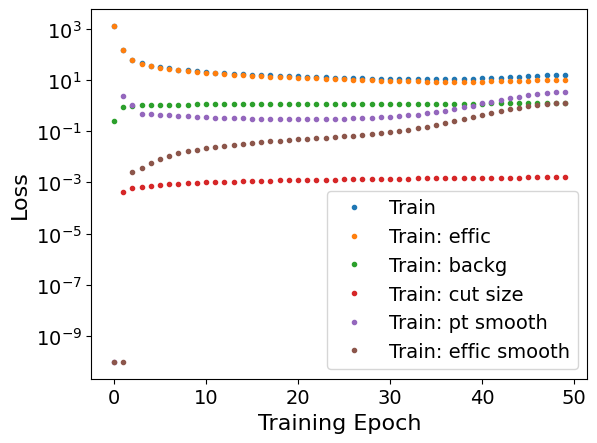

In [14]:
def plotlosses(losses, test_losses):
    plt.plot([l.totalloss().detach().numpy() for l in losses], '.', label="Train")
    #plt.plot([l.totalloss().detach().numpy() for l in test_losses], '.', label="Test")
    plt.plot([l.efficloss.detach().numpy() for l in losses], '.', label="Train: effic")
    plt.plot([l.backgloss.detach().numpy() for l in losses], '.', label="Train: backg")
    plt.plot([l.cutszloss.detach().numpy() for l in losses], '.', label="Train: cut size")
    # plt.plot([l.BCEloss.detach().numpy() for l in losses], '.', label="Train: BCE")
    if type(losses[0].ptloss) is not int:
        # this particular term can get very small, just cut it off for super small values
        plt.plot([max(l.ptloss.detach().numpy(),1e-10) for l in losses], '.', label="Train: pt smooth")
    if type(losses[0].muloss) is not int:
        plt.plot([max(l.muloss.detach().numpy(),1e-10) for l in losses], '.', label="Train: mu smooth")
    plt.plot([max(l.monotloss.detach().numpy(),1e-10) for l in losses], '.', label="Train: effic smooth")
    plt.legend()
    plt.xlabel('Training Epoch')
    plt.ylabel('Loss')
    plt.yscale('log');

plotlosses(losses,losses_test)